<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
    <p style="margin: 0; padding-top: 22px; text-align:right;"><b>Treball de Final de Màster </b></p>
<p style="margin: 0; text-align:right;"><b>ANÀLISI DEL DIA MUNDIAL DE LES MALALTIES MINORITÀRIES (Font de dades: TWITTER)</b>.</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Disseny i Implementació del TFM.

# Fase d'anàlisi: 
## Tècniques d'aprenentatge no supervisat per la detecció de comunitats i temàtiques.
### CLUSTERING - Algorismes KMeans.
<p style="color:#0000FF">
En aquest Jupyter Notebook, veurem com aplicar KMeans, el primer dels algorismes de clustering testejats.
    A diferència d'anàlisis anteriors, s'han introduït dues millores efectives, intentant optimitzar i ressoldre problemes de l'anàlisi inicial.
    En concret el excessiu volum de la matriu de vectorització, causat tant per un nombre gran de tuits com per un vocabulari molt extens amb
    paraules molt cops errònies.
    <br>
    Les mesures d'optimització aplicades són:<br>
</p>    
    <ol style="color:#0000FF">
        <li>Agrupar tots els textos d'un mateix autor dels tuits, i reduïr el nombre de files de la matriu de vectorització.</li>
        <li>Filtrar les paraules o vocabulari inclos en la vectorització, aplicant els filtres de nombre mínim i màxim d'aparicions possibles en cada tuit global de cada usuari.</li>
    </ol>
<p style="color:#0000FF">    
    Passem de considerar 98433 tuits a considerar 12408 sense perdre informació de contingut.<br>
    Passem d'un vocabulari de 19603 paraules a 213, amb la possible pèrdua de continguts o temàtiques minoritaris interessants.<br>
    Considerem les temàtiques a clústers definides per els mots més significatius, per tant també a part es podrien concloure temàtiques globals respecte
    el conjunt total de clústers.
</p>

<div style="text-align:right">
    <span style="font-family:calibri;font-size:8;color:white; background-color:Crimson; text-align:right; margin-left: 0.5cm;padding:0.3cm"> Autor: </span>
    <span style="font-family:calibri;font-size:8;color:white; background-color:RoyalBlue; text-align:center;  margin-right: 0.5cm; padding:0.3cm"><b> Joaquim de Dalmases Juanet </b></span>
</div>

In [4]:
#llibreria numpy per usar la funció min().
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Accés a la funció KMeans del mòdul cluster de la llibreria Skicit-learn.
from sklearn.cluster import KMeans, DBSCAN
# Visualització gràfica de matplotlib per Python.
import matplotlib.pyplot as plt
# Per el càlcul de durada dels processos.
import time
import delayedsparse
import scipy.sparse
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import re, collections
from textblob import TextBlob, Word
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.probability import FreqDist
from itertools import cycle, islice
from matplotlib.ticker import FormatStrFormatter
import logging
from sklearn.metrics import silhouette_score

D:\conda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [5]:
# Llegir el dataset
tuits = pd.read_excel("c:/users/qdeda/TFM_Code/DMMM_dataset_Final.xlsx")

In [6]:
# Transformacions:
t=tuits.drop(tuits[tuits.text_y.str.startswith('RT')].index)
# Juntem tuits d'un mateix autor.
t1 = t[['text_net','text_Norm','user_idstr']].groupby(['user_idstr']).agg(' '.join)
# Mitjana de polaritats i subjectivitats de tots els tuits
pol_subj = t[['user_idstr','polarity','subjectivity']].groupby(['user_idstr']).agg('mean')

# Eliminen paraules repetides
for row in t1.iterrows():
    tmp1=' '.join(set(row[1]['text_net'].split()))
    row[1]['text_net']=tmp1
    tmp2=' ' .join(set(row[1]['text_Norm'].split()))
    row[1]['text_Norm']=tmp2
# Reconstruim el dataset indexat per autor, perdem les identitats dels tuits
# tenim usuaris / paraules al construir el vector tfidf.
tuits = pd.merge(t1, pol_subj, left_on=t1.index, right_on=pol_subj.index, how='inner')
tuits.columns=['autor','text','text_norm','polaritat','subjectivitat']

# observem que les paraules obvies de hashtags queden per eliminar
excloure=['rare','day','today','february','disease','diseases','world']
for p in excloure:
    tuits.text=tuits.text.str.replace(p,"")
tuits.text

tuits=tuits.drop(tuits[tuits.text.str.len()==0].index)
tuits.reset_index(drop=True, inplace=True)
t=[]
t1=[]
t2=[]

In [7]:
tuits.head()


,autor,text,text_norm,polaritat,subjectivitat
0,284633,understand behind idea th shitty little visibi...,understand behind ide th sery vis littl shitty...,-0.306944,0.622222
1,286543,niente,nient,0.000000,0.000000
2,610873,cancer need support discovery researchers moti...,support discovery up doll thing bunch recogn y...,0.178329,0.623134
3,627213,autoimmune checked immunodeficiency fuckin dis...,cel autoimmun danlo fuckin prob lolol mystery ...,0.250000,0.650000
4,681573,idiocracy count,idiocr diseas count,0.000000,0.000000


In [8]:
# Millora respecte versió 1a d'aquest document
tfidf_vect = TfidfVectorizer(min_df=0.01)
matriu_tfidf = tfidf_vect.fit_transform(tuits.text)
matriu_tfidf.shape

(12390, 221)

In [9]:
# Apliquem reducció de dimensionalitat
# per millorar els resultats del clustering.

time_start = time.time()
X = matriu_tfidf
# reducció de la dimensionalitat amb PCA:
#pca = PCA(n_components=2)
n_comp=2
print("\nCreant el model i matriu PCA - Nº Components=",n_comp)
pca=delayedsparse.PCA(n_components=n_comp)
X_PCA = pca.fit(X).transform(X)
print("Dimensions de les dades reduïdes amb PCA:", np.shape(X_PCA))

temps=(time.time()-time_start)/60
print("#Reducció de dimensionalitat (PCA):",np.shape(X_PCA),"\n Durada: ",int(temps) if temps>0 else 0,"minut/s ", \
      int((temps-int(temps))*60),"segons.")


Creant el model i matriu PCA - Nº Components= 2
Dimensions de les dades reduïdes amb PCA: (12390, 2)
#Reducció de dimensionalitat (PCA): (12390, 2) 
 Durada:  0 minut/s  0 segons.


# Coeficient Silhouettes

Wall time: 1min 5s


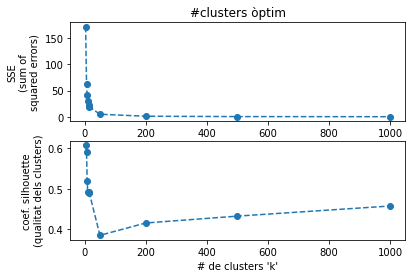

In [62]:
%%time
seed=88
# compare a broad range of ks to start
ks = [3, 6, 8, 10, 13, 15, 50, 200, 500, 1000]

# track a couple of metrics
sil_scores = []
inertias = []
# Si normalitzem els vectors, es com si en lloc d'utilitzar
# distància euclidea, usessim cosinus similarity.
X_Norm = X_PCA

# fit the models, save the evaluation metrics from each run
for k in ks:
    time_start = time.time()
    logging.warning('Aplicant el model per {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(X_Norm)
    labels = model.labels_
    sil_scores.append(silhouette_score(X_Norm, labels))
    inertias.append(model.inertia_)
    temps=(time.time()-time_start)/60
    logging.warning('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                     format(k, \
                           int(temps) if temps>0 else 0, \
                           int((temps-int(temps))*60))) 

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('SSE\n(sum of\nsquared errors)')
plt.title('#clusters òptim')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('coef. silhouette\n(qualitat dels clusters)')
plt.xlabel("# de clusters 'k'")
plt.savefig("kmeans_search_koptim_36810131550-1000.jpg",format='jpg',bbox_inches='tight')

Wall time: 1min 3s


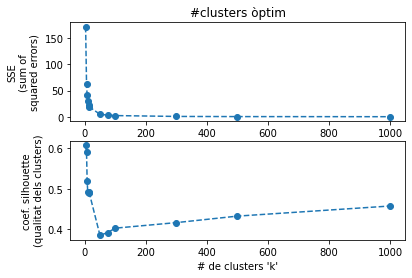

In [63]:
%%time
seed=88
# compare a broad range of ks to start
ks = [3, 6, 8, 10, 13, 15, 50, 75, 100, 300, 500, 1000]

# track a couple of metrics
sil_scores = []
inertias = []
# Si normalitzem els vectors, es com si en lloc d'utilitzar
# distància euclidea, usessim cosinus similarity.
X_Norm = X_PCA

# fit the models, save the evaluation metrics from each run
for k in ks:
    time_start = time.time()
    logging.warning('Aplicant el model per {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(X_Norm)
    labels = model.labels_
    sil_scores.append(silhouette_score(X_Norm, labels))
    inertias.append(model.inertia_)
    temps=(time.time()-time_start)/60
    logging.warning('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                     format(k, \
                           int(temps) if temps>0 else 0, \
                           int((temps-int(temps))*60))) 

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('SSE\n(sum of\nsquared errors)')
plt.title('#clusters òptim')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('coef. silhouette\n(qualitat dels clusters)')
plt.xlabel("# de clusters 'k'")
plt.savefig("kmeans_search_koptim_36810131550-300-1000.jpg",format='jpg',bbox_inches='tight')

In [44]:
# Funció que fa la correspondència entre clústers de
# visualització i vectorització
def mappings(counts,model):
    vpca=counts.argsort()[::-1]
    vtf=np.bincount(model.labels_).argsort()[::-1]
    mapa = {}
    for key, val in zip(vpca, vtf):
        mapa[key] = val
    return mapa

# Funció per determinar el comportament de cada clúster obtingut.
def tokens_rel_mes_propers(mapa, model, vectorizer, mat_vect, topk=10):
#    Representació text dels primers-k mots més propers al seu centroide
#    model: model de sklearn escollit.
#    vectorizer: tipus de vectorització (tfidf)
#    topk: nombre de paraules k seleccionades per cluster
    nom_model = model.__class__.__name__
    paraules = vectorizer.get_feature_names()
    if nom_model is 'KMeans':
        grups=np.bincount(model.labels_)
        etq_rellevants = list(set(model.labels_))
        centroides = model.cluster_centers_.argsort()[:,::-1]
        for id_cluster in etq_rellevants:
            print('Cluster {}: '.format(id_cluster))
            for ind in centroides[mapa[id_cluster], :topk]:
                print(' {}'.format(paraules[ind]), end='')
            print()

In [46]:
# CLUSTERING per KMeans

k_optim = 3
seed=88
X_Norm = X_PCA
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_3 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_3.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 3 clusters
Model finalitzat per 3 clusters. Temps: 0 min. 0 segs.


In [47]:
# Model en execució actual
model=km_model_3
# Definició del conjunt de colors o paleta de colors per la visualització.
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      int(len(set(model.labels_))))))

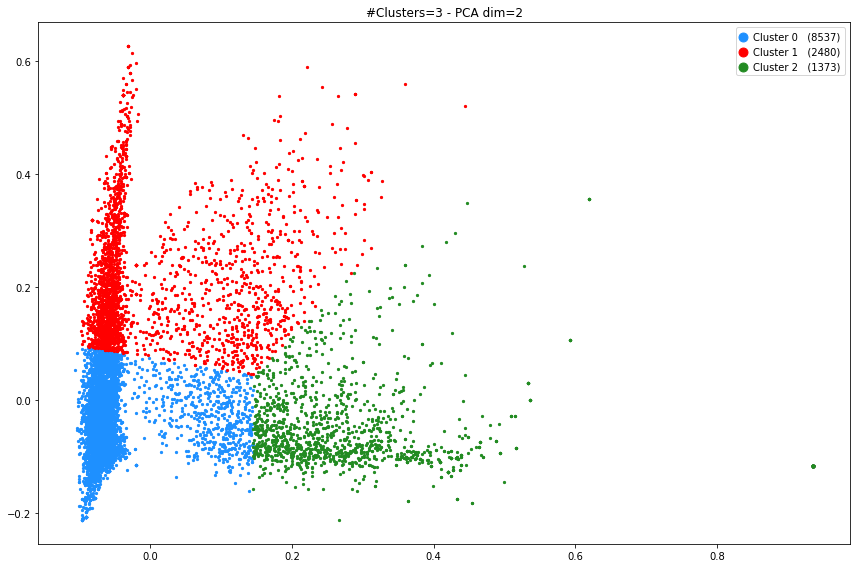

In [48]:
# Script de Visualització mitjançant scatter plot
# del model per K=8
num_clusters=k_optim
model=km_model_3
elements=np.bincount(model.labels_)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
for idcluster in range(0,num_clusters):  
    ax.scatter(np.array(X_PCA[:,0][model.labels_==idcluster]), np.array(X_PCA[:,1][model.labels_==idcluster]), \
               c=colors[idcluster], norm=norm, cmap=cmap, s=5, label="Cluster "+str(idcluster) + \
               "   ("+ str(np.bincount(model.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters, n_comp))
    ax.legend(handlelength=0.5, markerscale=4)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

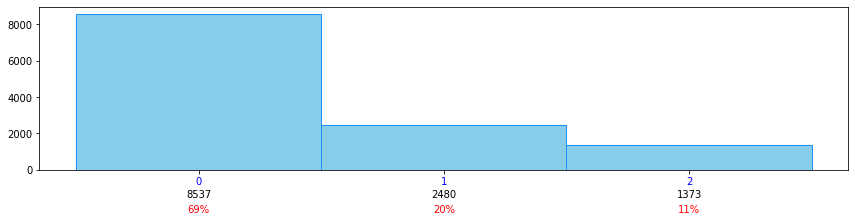

Nombre de tuits en el clúster més gran: 8537


In [49]:
# Representació de l'histograma resultat del CLUSTERING.
plt.figure()
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_).max()))

In [50]:
# CLUSTERING per KMeans
k_optim = 3
seed=88
X_Norm = matriu_tfidf
time_start = time.time()
print('Aplicant el model KMeans per {} clusters'.format(k_optim))
km_model_3 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_3.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model KMeans per 3 clusters
Model finalitzat per 3 clusters. Temps: 0 min. 7 segs.


In [51]:
mapa=mappings(counts,km_model_3)
tokens_rel_mes_propers(mapa, km_model_3, tfidf_vect, matriu_tfidf, topk=15)

Cluster 0: 
 research thank us patients support one know thanks like many happy tomorrow help life great
Cluster 1: 
 people awareness million raise living to support patients one raising wide help affected around know
Cluster 2: 
 to one celebrated support know every research us want year make work people celebrate many


In [52]:
# CLUSTERING per KMeans

k_optim = 6
seed=88
X_Norm = X_PCA
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_6 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_6.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 6 clusters
Model finalitzat per 6 clusters. Temps: 0 min. 0 segs.


In [53]:
# Model en execució actual
model=km_model_6
# Definició del conjunt de colors o paleta de colors per la visualització.
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      int(len(set(model.labels_))))))

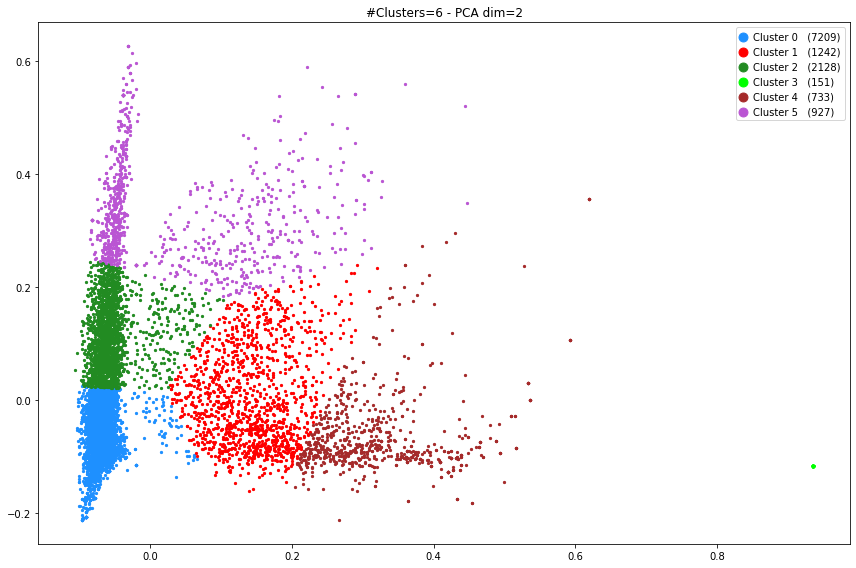

In [54]:
# Script de Visualització mitjançant scatter plot
# del model per K=8
num_clusters=k_optim
model=km_model_6
elements=np.bincount(model.labels_)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
for idcluster in range(0,num_clusters):  
    ax.scatter(np.array(X_PCA[:,0][model.labels_==idcluster]), np.array(X_PCA[:,1][model.labels_==idcluster]), \
               c=colors[idcluster], norm=norm, cmap=cmap, s=5, label="Cluster "+str(idcluster) + \
               "   ("+ str(np.bincount(model.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters, n_comp))
    ax.legend(handlelength=0.5, markerscale=4)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

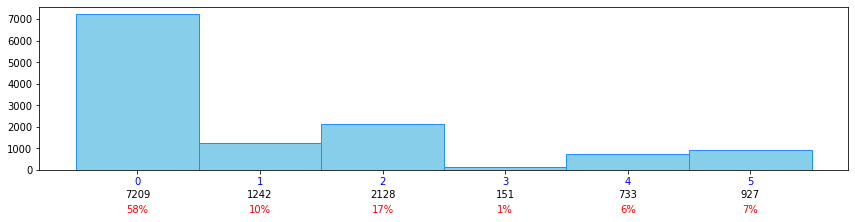

Nombre de tuits en el clúster més gran: 7209


In [55]:
# Representació de l'histograma resultat del CLUSTERING.
plt.figure()
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_).max()))

In [56]:
# CLUSTERING per KMeans
k_optim = 6
seed=88
X_Norm = matriu_tfidf
time_start = time.time()
print('Aplicant el model KMeans per {} clusters'.format(k_optim))
km_model_6 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_6.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model KMeans per 6 clusters
Model finalitzat per 6 clusters. Temps: 0 min. 6 segs.


In [58]:
mapa=mappings(counts,km_model_6)
tokens_rel_mes_propers(mapa, km_model_6, tfidf_vect, matriu_tfidf, topk=15)

Cluster 0: 
 thank us one patients support know like many tomorrow happy help great th life every
Cluster 1: 
 awareness raise raising to help people patients support impact lives living us families year join
Cluster 2: 
 people million living one wide to know around affected support many live suffer affect affects
Cluster 3: 
 thanks latest daily news to work thank sharing support great many every much us children
Cluster 4: 
 research support to patients treatments care us medical life find help treatment families cure people
Cluster 5: 
 to celebrated one support know want us every year celebrate international work many th make


In [38]:
# CLUSTERING per KMeans

k_optim = 8
seed=88
X_Norm = X_PCA
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_8 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_8.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 8 clusters
Model finalitzat per 8 clusters. Temps: 0 min. 2 segs.


In [39]:
# Model en execució actual
model=km_model_8
# Definició del conjunt de colors o paleta de colors per la visualització.
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      int(len(set(model.labels_))))))

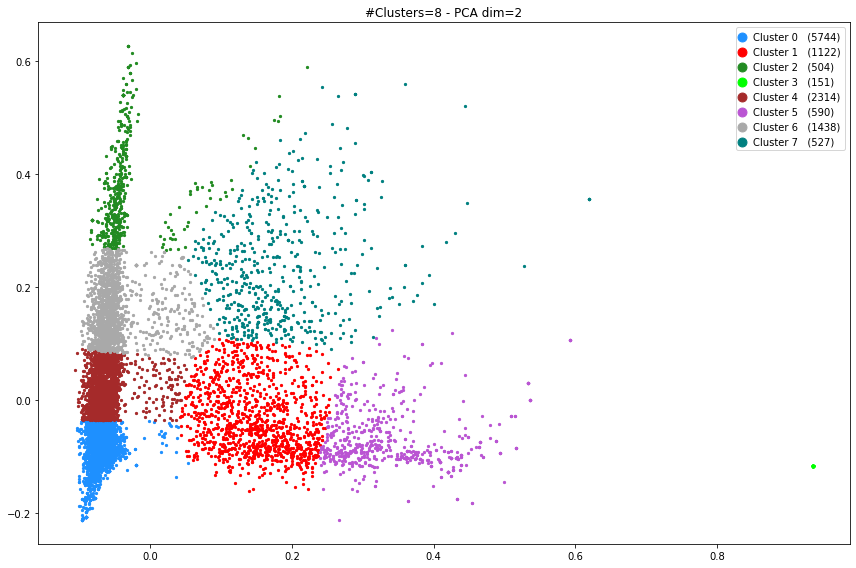

In [40]:
# Script de Visualització mitjançant scatter plot
# del model per K=8
num_clusters=k_optim
model=km_model_8
elements=np.bincount(model.labels_)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
for idcluster in range(0,num_clusters):  
    ax.scatter(np.array(X_PCA[:,0][model.labels_==idcluster]), np.array(X_PCA[:,1][model.labels_==idcluster]), \
               c=colors[idcluster], norm=norm, cmap=cmap, s=5, label="Cluster "+str(idcluster) + \
               "   ("+ str(np.bincount(model.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters, n_comp))
    ax.legend(handlelength=0.5, markerscale=4)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

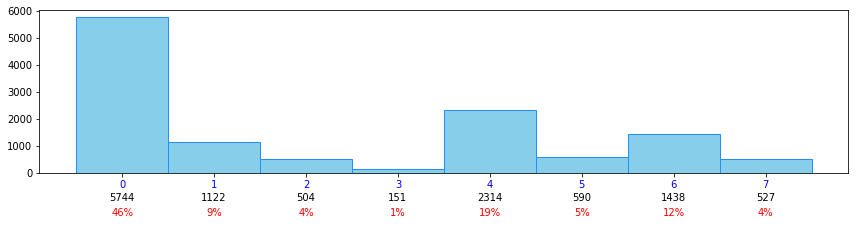

Nombre de tuits en el clúster més gran: 5744


In [41]:
# Representació de l'histograma resultat del CLUSTERING.
plt.figure()
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_).max()))

In [42]:
# CLUSTERING per KMeans
k_optim = 8
seed=88
X_Norm = matriu_tfidf
time_start = time.time()
print('Aplicant el model KMeans per {} clusters'.format(k_optim))
km_model_8 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_8.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 8 clusters
Model finalitzat per 8 clusters. Temps: 1 min. 4 segs.


In [45]:
mapa=mappings(counts,km_model_8)
tokens_rel_mes_propers(mapa, km_model_8, tfidf_vect, matriu_tfidf, topk=15)

Cluster 0: 
 thank happy know thanks latest syndrome years like good life th year also love every
Cluster 1: 
 awareness raise raising to help people patients impact lives living year families support please around
Cluster 2: 
 research support to care treatments medical patients life us find help new treatment cure need
Cluster 3: 
 support campaign official event to show people families patients please thank want proud living us
Cluster 4: 
 us patients tomorrow many great help new to thank families story work proud like every
Cluster 5: 
 to celebrated celebrate us every know work international want make th year learn years also
Cluster 6: 
 people million living wide to around affected know live affect suffer many treatment affects genetic
Cluster 7: 
 one to people year every know million affects diagnosed many syndrome living us get like


In [59]:
# CLUSTERING per KMeans

k_optim = 10
seed=88
X_Norm = X_PCA
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_10 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_10.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 10 clusters
Model finalitzat per 10 clusters. Temps: 0 min. 0 segs.


In [60]:
# Model en execució actual
model=km_model_10
# Definició del conjunt de colors o paleta de colors per la visualització.
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      int(len(set(model.labels_))))))

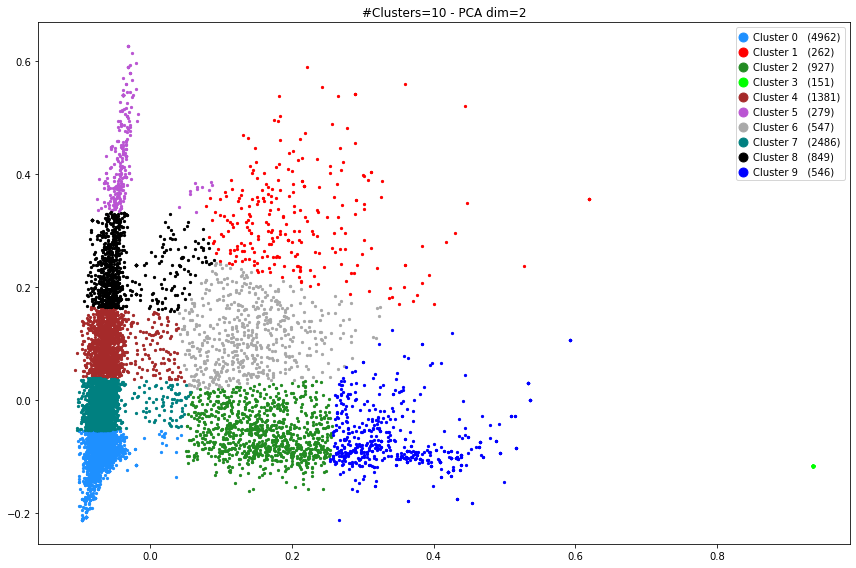

In [61]:
# Script de Visualització mitjançant scatter plot
# del model per K=8
num_clusters=k_optim
model=km_model_10
elements=np.bincount(model.labels_)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
for idcluster in range(0,num_clusters):  
    ax.scatter(np.array(X_PCA[:,0][model.labels_==idcluster]), np.array(X_PCA[:,1][model.labels_==idcluster]), \
               c=colors[idcluster], norm=norm, cmap=cmap, s=5, label="Cluster "+str(idcluster) + \
               "   ("+ str(np.bincount(model.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters, n_comp))
    ax.legend(handlelength=0.5, markerscale=4)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

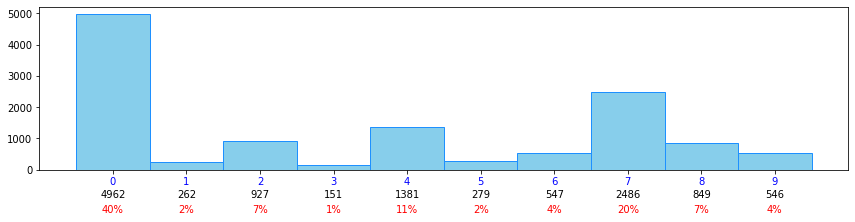

Nombre de tuits en el clúster més gran: 4962


In [62]:
# Representació de l'histograma resultat del CLUSTERING.
plt.figure()
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_).max()))

In [63]:
# CLUSTERING per KMeans
k_optim = 10
seed=88
X_Norm = matriu_tfidf
time_start = time.time()
print('Aplicant el model KMeans per {} clusters'.format(k_optim))
km_model_10 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_10.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model KMeans per 10 clusters
Model finalitzat per 10 clusters. Temps: 0 min. 6 segs.


In [64]:
mapa=mappings(counts,km_model_10)
tokens_rel_mes_propers(mapa, km_model_10, tfidf_vect, matriu_tfidf, topk=15)

Cluster 0: 
 thank happy patients many syndrome proud good life love also every work help story year
Cluster 1: 
 one to people year every million know affects diagnosed many syndrome us living hope get
Cluster 2: 
 know like years to people every life diagnosed many would syndrome diagnosis get still us
Cluster 3: 
 latest thanks daily news thank many to special read something research via genetic help syndrome
Cluster 4: 
 people million living wide to around affected live affect many suffer treatment know awareness help
Cluster 5: 
 research support to care treatments patients medical life us find help treatment families new work
Cluster 6: 
 to celebrated celebrate every us make work want year many international learn th people see
Cluster 7: 
 us tomorrow great th new health thank patients to help work see join patient year
Cluster 8: 
 awareness raise raising to help patients people impact lives living year families join support please
Cluster 9: 
 support campaign official to ev

In [65]:
# CLUSTERING per KMeans

k_optim = 13
seed=88
X_Norm = X_PCA
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_13 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_13.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 13 clusters
Model finalitzat per 13 clusters. Temps: 0 min. 0 segs.


In [66]:
# Model en execució actual
model=km_model_13
# Definició del conjunt de colors o paleta de colors per la visualització.
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      int(len(set(model.labels_))))))

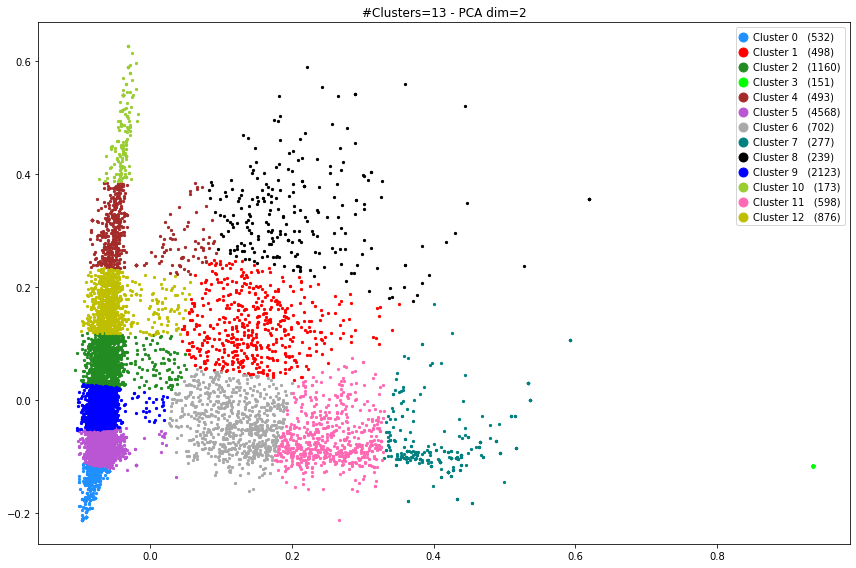

In [67]:
# Script de Visualització mitjançant scatter plot
# del model per K=8
num_clusters=k_optim
model=km_model_13
elements=np.bincount(model.labels_)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
for idcluster in range(0,num_clusters):  
    ax.scatter(np.array(X_PCA[:,0][model.labels_==idcluster]), np.array(X_PCA[:,1][model.labels_==idcluster]), \
               c=colors[idcluster], norm=norm, cmap=cmap, s=5, label="Cluster "+str(idcluster) + \
               "   ("+ str(np.bincount(model.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters, n_comp))
    ax.legend(handlelength=0.5, markerscale=4)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

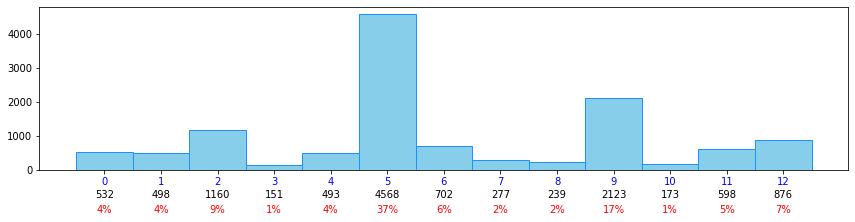

Nombre de tuits en el clúster més gran: 4568


In [68]:
# Representació de l'histograma resultat del CLUSTERING.
plt.figure()
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_).max()))

In [69]:
# CLUSTERING per KMeans
k_optim = 13
seed=88
X_Norm = matriu_tfidf
time_start = time.time()
print('Aplicant el model KMeans per {} clusters'.format(k_optim))
km_model_13 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_13.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model KMeans per 13 clusters
Model finalitzat per 13 clusters. Temps: 0 min. 5 segs.


In [70]:
mapa=mappings(counts,km_model_13)
tokens_rel_mes_propers(mapa, km_model_13, tfidf_vect, matriu_tfidf, topk=15)

Cluster 0: 
 one to people year every know diagnosed million syndrome affects hope get best life us
Cluster 1: 
 many strong proud people to one every living live like know million thanks go us
Cluster 2: 
 awareness raise raising to help people impact patients lives families year living please support public
Cluster 3: 
 celebrated to th last tomorrow year every awareness campaign satur know want hope years since
Cluster 4: 
 research support to treatments need new help find hope read treatment patients cure care families
Cluster 5: 
 thank thanks latest like syndrome tomorrow years good work th every year event also new
Cluster 6: 
 patients families to patient treatment read hope sharing story research supporting work support learn help
Cluster 7: 
 support to show people families please want thank suffer patients proud need living help us
Cluster 8: 
 great work see thank event to support team thanks awareness people like family us much
Cluster 9: 
 us know life to people help than

In [71]:
# CLUSTERING per KMeans

k_optim = 15
seed=88
X_Norm = X_PCA
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_15 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_15.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 15 clusters
Model finalitzat per 15 clusters. Temps: 0 min. 0 segs.


In [72]:
# Model en execució actual
model=km_model_15
# Definició del conjunt de colors o paleta de colors per la visualització.
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      int(len(set(model.labels_))))))

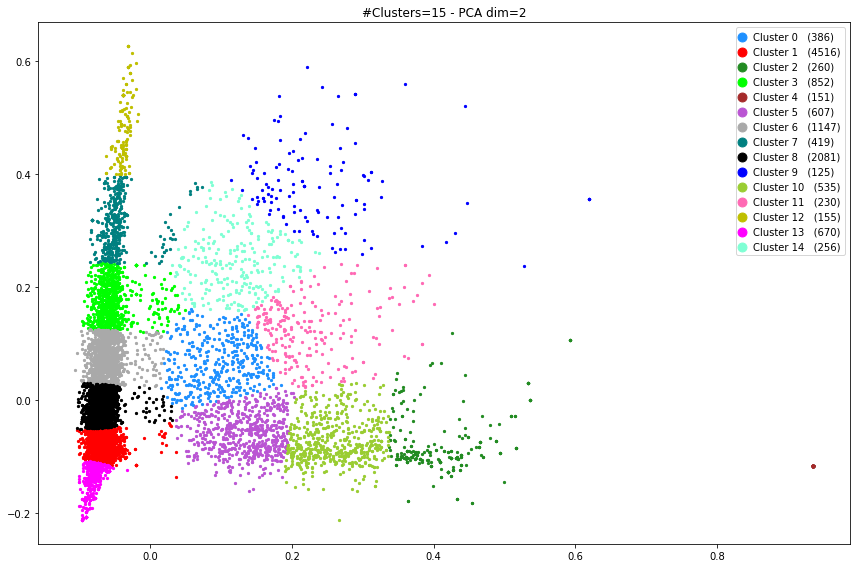

In [73]:
# Script de Visualització mitjançant scatter plot
# del model per K=8
num_clusters=k_optim
model=km_model_15
elements=np.bincount(model.labels_)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
for idcluster in range(0,num_clusters):  
    ax.scatter(np.array(X_PCA[:,0][model.labels_==idcluster]), np.array(X_PCA[:,1][model.labels_==idcluster]), \
               c=colors[idcluster], norm=norm, cmap=cmap, s=5, label="Cluster "+str(idcluster) + \
               "   ("+ str(np.bincount(model.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters, n_comp))
    ax.legend(handlelength=0.5, markerscale=4)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

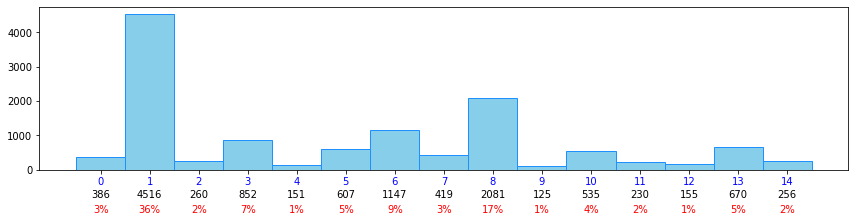

Nombre de tuits en el clúster més gran: 4516


In [74]:
# Representació de l'histograma resultat del CLUSTERING.
plt.figure()
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_).max()))

In [75]:
# CLUSTERING per KMeans
k_optim = 15
seed=88
X_Norm = matriu_tfidf
time_start = time.time()
print('Aplicant el model KMeans per {} clusters'.format(k_optim))
km_model_15 = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_15.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model KMeans per 15 clusters
Model finalitzat per 15 clusters. Temps: 0 min. 5 segs.


In [76]:
mapa=mappings(counts,km_model_15)
tokens_rel_mes_propers(mapa, km_model_15, tfidf_vect, matriu_tfidf, topk=15)

Cluster 0: 
 research support to treatments new find treatment need help hope diagnosis cure care work read
Cluster 1: 
 thank thanks latest like syndrome tomorrow years good th event work new every international year
Cluster 2: 
 many strong proud people to one every live know living like million thanks th awareness
Cluster 3: 
 patients families to help research supporting people patient read support affected treatment hope sharing work
Cluster 4: 
 happy everyone us to year people living many good celebrate one awareness amazing friends also
Cluster 5: 
 to celebrate work make years give international want th year celebrating every learn see tomorrow
Cluster 6: 
 awareness raise raising to help impact people lives patients year public please support families living
Cluster 7: 
 one to people year every diagnosed know affects million syndrome get hope best like us
Cluster 8: 
 us know life to help thank let join please like care tomorrow get people learn
Cluster 9: 
 celebrated to la

### Exemple d'Interpretació de Temàtiques
<p style="color:#0000FF; font-size:18px">
    Cluster 0: Suport a la investigació de tractaments nous per afectats que esperen un diagnostic.<br>
    Cluster 1: Agraiments per un any més d'èxit en la resposta a un esdeveniment en relació al DMMM.<br>
    Cluster 2: Fa ressò en ser conscients de les malalties minoritàries (MM).<br>
    Cluster 3: Petició de suport a la investigació de tractaments i suport a les families de pacients.<br>
    Cluster 4: Satisfacció de tots de celebrar el dia i prendre consciencia de les MM.<br>
    Cluster 5: Sobre treballar per internacionalitzar i aprendre cada any amb la celebració del dia MM.<br>
    Cluster 6: Petició de suport pels qui pateixen malalties minoritàries i per les seves famílies.<br>
    Cluster 7: Temps de diagnostic un any a pacients i millorar l'esperança per milions de persones.<br>
    Cluster 8: Petició d'ajuda, animar a que la gent conegui durant el dia MM.<br>
    Cluster 9: Necessitat de campanyes cada any i ser conscients de les MM.<br>
   Cluster 10: Reduir/vigilar el nombre de diagnostics als afectats que pateixen transtorns.<br> 
   Cluster 11: Investigació i la importància de promocionar-ho el dia 29.<br>
   Cluster 12: Agraiments envers la celebració d'un event, bona resposta de l'esdeveniment per part de les persones.<br>
   Cluster 13: Sensibilització i ser conscients pels que pateixen per obtenir tractaments / milions de persones.<br>
   Cluster 14: Petició de campanyes de suport a pacients i families a viure a més del dia MM.<br> 
</p>

## CAS ANÀLISI DE SENTIMENTS

### CAS DE TUITS A FAVOR

In [77]:
# filtrem aquells tuits amb subjectivitat >0.5
tuits_subj=tuits[tuits.subjectivitat>0.5]
tuits_subj.shape

(6461, 5)

In [78]:
# tuits subjectius positivament
tuits_pos=tuits_subj[tuits_subj.polaritat>0.5]
print(tuits_pos.shape)

(826, 5)


In [79]:
# tuits subjectius negativament
tuits_neg=tuits_subj[tuits_subj.polaritat<-0.5]
tuits_neg.shape

(79, 5)

In [80]:
tfidf_vect_pos = TfidfVectorizer()
matriu_tfidf_pos = tfidf_vect_pos.fit_transform(tuits_pos.text)

tfidf_vect_neg = TfidfVectorizer()
matriu_tfidf_neg = tfidf_vect_neg.fit_transform(tuits_neg.text)

In [81]:
print(matriu_tfidf_pos.shape)
print(matriu_tfidf_neg.shape)

(826, 2526)
(79, 461)


In [89]:
# Apliquem reducció de dimensionalitat
# per millorar els resultats del clustering.

time_start = time.time()
X = matriu_tfidf_pos
# reducció de la dimensionalitat amb PCA:
#pca = PCA(n_components=2)
n_comp=2
print("\nCreant el model i matriu PCA - Nº Components=",n_comp)
pca=delayedsparse.PCA(n_components=n_comp)
X_PCA_pos = pca.fit(X).transform(X)
print("Dimensions de les dades reduïdes amb PCA:", np.shape(X_PCA_pos))

temps=(time.time()-time_start)/60
print("#Reducció de dimensionalitat (PCA):",np.shape(X_PCA_pos),"\n Durada: ",int(temps) if temps>0 else 0,"minut/s ", \
      int((temps-int(temps))*60),"segons.")


Creant el model i matriu PCA - Nº Components= 2
Dimensions de les dades reduïdes amb PCA: (826, 2)
#Reducció de dimensionalitat (PCA): (826, 2) 
 Durada:  0 minut/s  0 segons.


In [90]:
# CLUSTERING per KMeans
# num clústers en k_optim
k_optim = 10
seed=88
X_Norm = X_PCA_pos
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_pos = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_pos.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 10 clusters
Model finalitzat per 10 clusters. Temps: 0 min. 0 segs.


In [91]:
colors_pos = np.array(list(islice(cycle(['dodgerblue', 'orange', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'y',
                                     'blue','red','hotpink','black' ]),
                                      int(max(km_model_pos.labels_) + 1))))

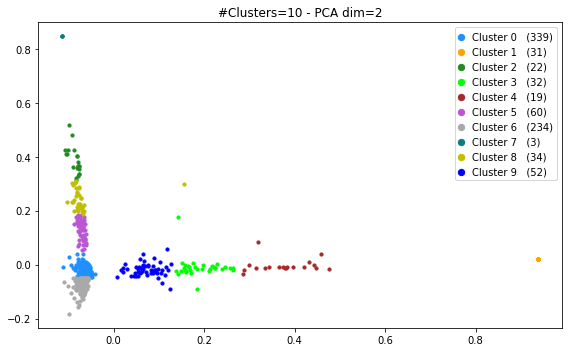

In [92]:
num_clusters_pos=k_optim
elements_pos=np.bincount(km_model_pos.labels_)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters_pos-1)
for idcluster in range(0,num_clusters_pos):  
    ax.scatter(np.array(X_PCA_pos[:,0][km_model_pos.labels_==idcluster]), np.array(X_PCA_pos[:,1][km_model_pos.labels_==idcluster]), \
               c=colors_pos[idcluster], norm=norm, cmap=cmap, s=10, label="Cluster "+str(idcluster) + \
               "   ("+str(np.bincount(km_model_pos.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters_pos, n_comp))
    ax.legend(handlelength=0.5, markerscale=2)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_POS_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

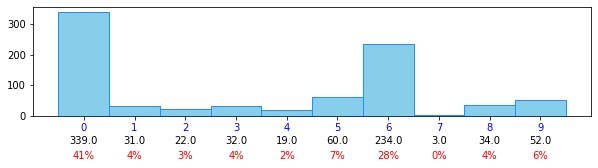

Nombre de tuits en el clúster més gran: 339


In [93]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,2))
counts, bins, patches = plt.hist(km_model_pos.labels_, bins=np.array(range(0,num_clusters_pos+1)), facecolor='skyblue', edgecolor='dodgerblue')

ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]

ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')

for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_POS_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(km_model_pos.labels_).max()))

In [87]:
#Positius
k_optim = num_clusters_pos
seed=88
X_Norm = matriu_tfidf_pos
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_pos = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_pos.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 10 clusters
Model finalitzat per 10 clusters. Temps: 0 min. 1 segs.


In [88]:
mapa=mappings(counts,km_model_pos)
tokens_rel_mes_propers(mapa, km_model_pos, tfidf_vect_pos, matriu_tfidf_pos, topk=15)

Cluster 0: 
 happy beautiful to latest important awareness nice excellent people living one support interesting year best
Cluster 1: 
 amazing work inspiring awareness families daughter friend to support like around things resilient meet raising
Cluster 2: 
 happy national friends celebrating affected everyone us to forms forward fortunate food fort force forces
Cluster 3: 
 wonderful thank latest diario el to work de helping sharing support great spend us news
Cluster 4: 
 uncommon to pathologies spain cancers people estimated treatment lupus wide th million research beauty thank
Cluster 5: 
 great work see support to awareness people know opportunity team research time come job interview
Cluster 6: 
 proud support work many patients strong part community to us join million every team families
Cluster 7: 
 love someone abigail champ sending would full need paints rock star community adorable bringing tell
Cluster 8: 
 awesome event dr great sure way make perfect like could thanks feb 

In [129]:
# Analisi del contingut dels clusters - Temàtiques

### TUITS SENTIMENT ANALISI EN CONTRA

In [94]:
# Apliquem reducció de dimensionalitat
# per millorar els resultats del clustering.

time_start = time.time()
X = matriu_tfidf_neg
# reducció de la dimensionalitat amb PCA:
#pca = PCA(n_components=2)
n_comp=2
print("\nCreant el model i matriu PCA - Nº Components=",n_comp)
pca=delayedsparse.PCA(n_components=n_comp)
X_PCA_neg = pca.fit(X).transform(X)
print("Dimensions de les dades reduïdes amb PCA:", np.shape(X_PCA_neg))

temps=(time.time()-time_start)/60
print("#Reducció de dimensionalitat (PCA):",np.shape(X_PCA_neg),"\n Durada: ",int(temps) if temps>0 else 0,"minut/s ", \
      int((temps-int(temps))*60),"segons.")


Creant el model i matriu PCA - Nº Components= 2
Dimensions de les dades reduïdes amb PCA: (79, 2)
#Reducció de dimensionalitat (PCA): (79, 2) 
 Durada:  0 minut/s  0 segons.


In [95]:
# CLUSTERING per KMeans
# num clústers en k_optim
k_optim = 12
seed=88
X_Norm = X_PCA_neg
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_neg = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_neg.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 12 clusters
Model finalitzat per 12 clusters. Temps: 0 min. 2 segs.


In [96]:
colors_neg = np.array(list(islice(cycle(['dodgerblue', 'orange', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'y',
                                     'blue','red','hotpink','black' ]),
                                      int(max(km_model_neg.labels_) + 1))))

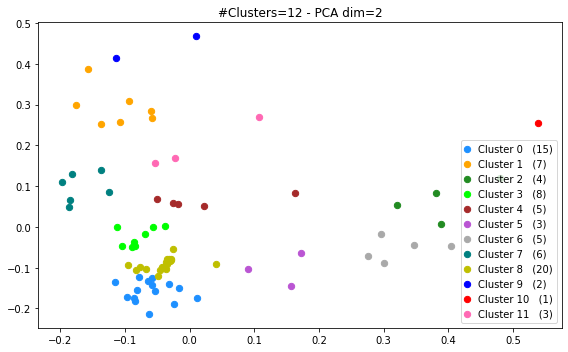

In [97]:
num_clusters_neg=k_optim
elements_neg=np.bincount(km_model_neg.labels_)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters_neg-1)
for idcluster in range(0,num_clusters_neg):  
    ax.scatter(np.array(X_PCA_neg[:,0][km_model_neg.labels_==idcluster]), np.array(X_PCA_neg[:,1][km_model_neg.labels_==idcluster]), \
               c=colors_neg[idcluster], norm=norm, cmap=cmap, s=40, label="Cluster "+str(idcluster) + \
               "   ("+str(np.bincount(km_model_neg.labels_)[idcluster]) + ")")
    ax.set_title('#Clusters={} - PCA dim={}'.format(num_clusters_neg, n_comp))
    ax.legend(loc='lower right', handlelength=0.5, markerscale=1)
plt.tight_layout()
plt.savefig("scatter_kmeans_PCA_NEG_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

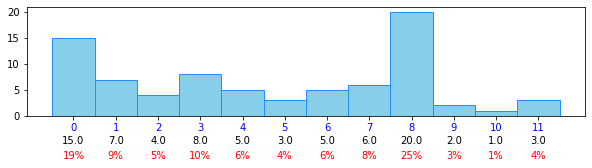

Nombre de tuits en el clúster més gran: 20


In [99]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,2))
counts, bins, patches = plt.hist(km_model_neg.labels_, bins=np.array(range(0,num_clusters_neg+1)), facecolor='skyblue', edgecolor='dodgerblue')

ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]

ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')

for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_kmeans_PCA_NEG_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(km_model_neg.labels_).max()))

In [100]:
# Tuits Negatius
k_optim = num_clusters_neg
seed=88
X_Norm = matriu_tfidf_neg
time_start = time.time()
print('Aplicant el model per {} clusters'.format(k_optim))
km_model_neg = KMeans(n_clusters=k_optim, n_jobs=-1, random_state=seed)
km_model_neg.fit(X_Norm)
temps=(time.time()-time_start)/60
print('Model finalitzat per {} clusters. Temps: {} min. {} segs.'. \
                format(k_optim, \
                       int(temps) if temps>0 else 0, \
                       int((temps-int(temps))*60)))

Aplicant el model per 12 clusters
Model finalitzat per 12 clusters. Temps: 0 min. 0 segs.


In [102]:
# Avaluació dels continguts dels clusters

In [103]:
mapa=mappings(counts,km_model_neg)
tokens_rel_mes_propers(mapa, km_model_neg, tfidf_vect_neg, matriu_tfidf_neg, topk=15)

Cluster 0: 
 illness invisible horrible painful let suffer aura migraine please terrible change research weird fight stop
Cluster 1: 
 cold always reason feet hands urticaria allergy allergic count um milling think they summer oh
Cluster 2: 
 happened years almost three thing worst writing suffered awful hysterical struggling alone diagnosed badly treated
Cluster 3: 
 sick pope common support life wrestlers forget fam showing joins patients chosen million exigimos concience
Cluster 4: 
 devastating conditions psp awareness please support share fondness convivir magnitude people raise cbd neurological misdiagnosis
Cluster 5: 
 bad tts bunny derived solution understands god spends hands one friend forget foundation four fondness
Cluster 6: 
 one to frustrating suffers adrenoleucodystrophy hijo sick called talked talk press continue voice society give
Cluster 7: 
 condition know improve dreadful needs care comprehensive honor might things sick business look patient miserable
Cluster 8: 
 

## RECERCA NOMBRE DE CLÚSTERS ÒPTIM PER KMEANS

In [207]:

def test_colze(X,llista_k):
    tamFont=14; c1='b'; seed=88;
    c2='dodgerblue'
    errorsMitjana=[]
    print("Testejant valors de k en {}\n".format(llista_k))
    time_start0=time.time()
    for k in llista_k:
        time_start=time.time()
        kmeans=KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
        kmeans.fit(X)
        temps=(time.time()-time_start)/60
        print("#Per K=:",k,"\n Durada: ",int(temps) if temps>0 else 0,"minut/s ", \
              int((temps-int(temps))*60),"segons.")
        # Càlcul SSE:
        #errorsMitjana.append(sum(np.min(cdist(X,kmeans.cluster_centers_,"euclidean"), axis=1))/X.shape[0])
        # També tenim el paràmetre de sortida 'inertia_' de KMeans calculat.
        # i podriem usar-lo:   
        errorsMitjana.append(np.sqrt(kmeans.inertia_)/X.shape[0])
    plt.xlabel("k",fontsize=tamFont,color=c1)
    plt.ylabel("SSE",fontsize=tamFont,color=c1)
    plt.title("Mètode del colze (Selecció de k)",fontsize=tamFont+1,color=c1)
    plt.plot(llista_k,errorsMitjana,"bo-",color=c2)
    
    temps=(time.time()-time_start0)/60
    print("\n Durada Final: ",int(temps) if temps>0 else 0,"minut/s ", \
          int((temps-int(temps))*60),"segons.")
    return errorsMitjana

### Nombre de clústers òptim per el conjunt global de tuits

Testejant valors de k en [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 100, 200, 300, 500, 1000]

#Per K=: 2 
 Durada:  0 minut/s  3 segons.
#Per K=: 3 
 Durada:  0 minut/s  7 segons.
#Per K=: 4 
 Durada:  0 minut/s  7 segons.
#Per K=: 5 
 Durada:  0 minut/s  5 segons.
#Per K=: 6 
 Durada:  0 minut/s  6 segons.
#Per K=: 7 
 Durada:  0 minut/s  5 segons.
#Per K=: 8 
 Durada:  0 minut/s  25 segons.
#Per K=: 9 
 Durada:  0 minut/s  6 segons.
#Per K=: 10 
 Durada:  0 minut/s  31 segons.
#Per K=: 20 
 Durada:  0 minut/s  28 segons.
#Per K=: 30 
 Durada:  0 minut/s  8 segons.
#Per K=: 40 
 Durada:  0 minut/s  7 segons.
#Per K=: 50 
 Durada:  0 minut/s  7 segons.
#Per K=: 60 
 Durada:  0 minut/s  9 segons.
#Per K=: 100 
 Durada:  0 minut/s  7 segons.
#Per K=: 200 
 Durada:  0 minut/s  7 segons.
#Per K=: 300 
 Durada:  0 minut/s  10 segons.
#Per K=: 500 
 Durada:  0 minut/s  14 segons.
#Per K=: 1000 
 Durada:  0 minut/s  23 segons.

 Durada Final:  3 minut/s  46 segons.


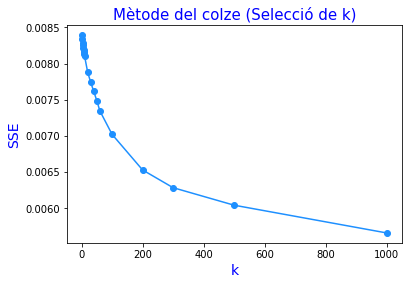

In [208]:
errorsMitjana = test_colze(matriu_tfidf,[2,3,4,5,6,7,8,9,10,20,30,40,50,60,100,200,300,500,1000])

### Test colze per determinar el nombre de clústers òptim de tuits a favor

Testejant valors de k en [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 80]

#Per K=: 2 
 Durada:  0 minut/s  0 segons.
#Per K=: 3 
 Durada:  0 minut/s  0 segons.
#Per K=: 4 
 Durada:  0 minut/s  0 segons.
#Per K=: 5 
 Durada:  0 minut/s  0 segons.
#Per K=: 6 
 Durada:  0 minut/s  0 segons.
#Per K=: 7 
 Durada:  0 minut/s  0 segons.
#Per K=: 8 
 Durada:  0 minut/s  0 segons.
#Per K=: 9 
 Durada:  0 minut/s  0 segons.
#Per K=: 10 
 Durada:  0 minut/s  0 segons.
#Per K=: 11 
 Durada:  0 minut/s  0 segons.
#Per K=: 12 
 Durada:  0 minut/s  0 segons.
#Per K=: 13 
 Durada:  0 minut/s  0 segons.
#Per K=: 14 
 Durada:  0 minut/s  0 segons.
#Per K=: 15 
 Durada:  0 minut/s  0 segons.
#Per K=: 20 
 Durada:  0 minut/s  0 segons.
#Per K=: 30 
 Durada:  0 minut/s  0 segons.
#Per K=: 40 
 Durada:  0 minut/s  0 segons.
#Per K=: 50 
 Durada:  0 minut/s  0 segons.
#Per K=: 80 
 Durada:  0 minut/s  0 segons.

 Durada Final:  0 minut/s  0 segons.


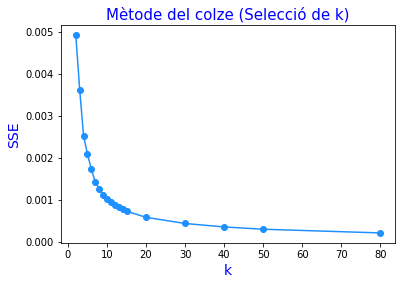

In [191]:
errorsMitjana = test_colze(X_PCA_pos,[2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,80])

### Test colze per determinar el nombre de clústers òptim de tuits en contra

Testejant valors de k en [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 20, 25, 30, 35, 40, 45, 50, 60]

#Per K=: 2 
 Durada:  0 minut/s  0 segons.
#Per K=: 3 
 Durada:  0 minut/s  0 segons.
#Per K=: 4 
 Durada:  0 minut/s  0 segons.
#Per K=: 5 
 Durada:  0 minut/s  0 segons.
#Per K=: 6 
 Durada:  0 minut/s  0 segons.
#Per K=: 7 
 Durada:  0 minut/s  0 segons.
#Per K=: 8 
 Durada:  0 minut/s  0 segons.
#Per K=: 9 
 Durada:  0 minut/s  0 segons.
#Per K=: 10 
 Durada:  0 minut/s  0 segons.
#Per K=: 13 
 Durada:  0 minut/s  0 segons.
#Per K=: 20 
 Durada:  0 minut/s  0 segons.
#Per K=: 25 
 Durada:  0 minut/s  0 segons.
#Per K=: 30 
 Durada:  0 minut/s  0 segons.
#Per K=: 35 
 Durada:  0 minut/s  0 segons.
#Per K=: 40 
 Durada:  0 minut/s  0 segons.
#Per K=: 45 
 Durada:  0 minut/s  0 segons.
#Per K=: 50 
 Durada:  0 minut/s  0 segons.
#Per K=: 60 
 Durada:  0 minut/s  0 segons.

 Durada Final:  0 minut/s  0 segons.


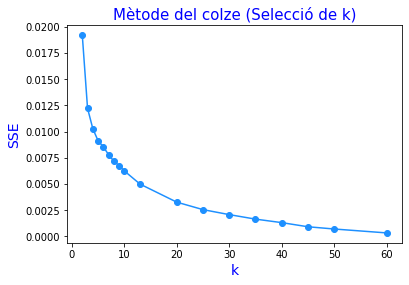

In [192]:
errorsMitjana = test_colze(X_PCA_neg,[2,3,4,5,6,7,8,9,10,13,20,25,30,35,40,45,50,60])